<a href="https://colab.research.google.com/github/caiJiYiMei/2018-Chinese-National-College-Students-Mathematical-Modeling/blob/master/derive_free_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up your google drive
After these step you can use GPU to accelerate your algorithm.

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:

import keras
import tensorflow as tf
tf.test.gpu_device_name() 

'/device:GPU:0'

# Three methods to solve LQR control problem
###Model based control: LQR



*  System model

  $$\min\ \mathbb{E}\left[\sum_{t=0}^{\infty}\left(x_{t}^{\top} Q x_{t}+u_{t}^{\top} R u_{t}\right)\right]$$
   $$s.t.\ \ x_{t+1}=A x_{t}+B u_{t}, \quad x_{0} \sim \mathcal{D}$$
   where initial state $\quad x_{0} \sim \mathcal{D}$ is assumed to be randomly distributed according to distribution $\mathcal{D}$ ; the matrices $A \in R^{d×d}$ and $B ∈ R^{d×k}$ are referred to as system (or transition) matrices; $Q ∈ R^{d×d}$ and $R ∈ R^{k×k}$ are both positive definite matrices that parameterize the quadratic costs. For clarity, this work does not consider a noise disturbance but only a random initial state. 
   The optimal control input can be written as a linear function in the state:
   $$u_{t}=-K^{*} x_{t},\ \  K^{*} \in \mathbb{R}^{k \times d}$$
   planning can be achieved by solving the Algebraic Riccati Equation (ARE):
   $$P=A^{T} P A+Q-A^{T} P B\left(B^{T} P B+R\right)^{-1} B^{T} P A$$
   $$K^{*}=-\left(B^{T} P B+R\right)^{-1} B^{T} P A$$
   \begin{array}{l}{\text { Simply run the recursion } P_{k+1}=Q+A^{T} P_{k} A-} \\ {A^{T} P_{k} B\left(R+B^{T} P_{k} B\right)^{-1} B^{T} P_{k} A \text { where } P_{1}=Q}\end{array}
   
  Note: When $t$ is much smaller than $N$, the steady-state $P$ can approximately converge and satisfy the ARE. Therefore, when the time $t$ is far from the time end point $N$, the control rate of the LQR can be approximated as a constant feedback of the state $x_t$.

*  Cost function (reward)
    $$\mathcal{C}_{\text { init, } \gamma}\left(K ; s_{0}\right) :=\sum_{t=0}^{\infty}\left(s_{t}^{\top} Q s_{t}+a_{t}^{\top} R a_{t}\right)$$
    where we have the noiseless dynamics $s_{t+1} = As_t+Ba_t$ a random variable that denotes some notion of sample and $a_t = −K^*s_t$ for each $t ≥ 0$. While $Cinit,γ(K; s_0)$ is cost, our goal is to minimize the population cost
    $$\mathcal{C}_{\text { init }, \gamma}(K) :=\mathbb{E}_{s_{0} \sim \mathcal{D}_{0}}\left[\mathcal{C}_{\text { init }, \gamma}\left(K ; s_{0}\right)\right]$$
    
  A policy $K$ is said to stabilize the system $(A,B)$ if we spectral radius of a matrix. We assume throughout have $ρ_{spec}(A − BK) < 1$, where $ρ_{spec}(·)$ denotes the spectral radius of a matrix. 


In [0]:
import numpy as np
import pandas as pd
import math
import random

'''
Calculate the optimal control gain of LQR through A, B, Q, R.
All inputs should be numpy object.
 
'''

def optimal_lqr_gain(A, B, Q, R):
  (k, d) = [A.shape[0], B.shape[0]]
  K_star = np.zeros((k, d))
  P0 = Q
  P1 = Q
  error = 1
  N = 1
  while(error >= 0.000001):
    P0 = P1
    temp0 = np.dot(A.transpose(), P0)
    temp1 = np.dot(B.transpose(), P0)
    temp2 = np.dot(temp0, B)
    temp3 = np.dot(temp1, A)
    temp4 = np.linalg.inv(R + np.dot(temp1, B))
    P1 = Q + np.dot(np.dot(A.transpose(), P0), A) - np.dot(np.dot(temp2, temp4), temp3)
    error = abs(np.linalg.norm(P0 - P1))
  temp5 = np.dot(B.transpose(), P1)
  temp6 = np.dot(temp5, A)
  temp7 = np.linalg.inv(R + np.dot(temp5, B))
  K_star = -np.dot(temp7, temp6)
  return -K_star
  
  
'''
Calculate optimal control reward based on optimal gain calcualted before and
the initial state was sampled uniformly at random from the canonical basis vectors.
'''  

def aux_lqr_reward(x0, K, A, B, Q, R):
  reward0 = 0
  reward1 = 0
  x1 = x0
  error = 1
  N = 1
  while(error >= 0.0001):
    reward0 = reward1
    x0 = x1
    ut = -np.dot(K, x0)
    reward1 = np.dot(np.dot(x0.transpose(), Q), x0) + np.dot(np.dot(ut.transpose(), R), ut) + reward0
    x1 = np.dot(A, x0) + np.dot(B, ut)
    error = abs(np.linalg.norm(reward1 - reward0))
    N = N + 1
  return reward1

def optimal_lqr_reward(A, B, Q, R):
  N = 10000
  (k, d) = [A.shape[0], B.shape[0]]
  sum_reward = 0
  K = optimal_lqr_gain(A, B, Q, R)
  for k in range(0, N):
    x0 = np.array([[random.randint(0, 100000)/10000 for i in range(d)]]).transpose()
    sum_reward = sum_reward + aux_lqr_reward(x0, K, A, B, Q, R)
  return sum_reward/N
  
  
'''
Test all model-based LQR function
'''  

def test_opt_gain():
  A = np.array([[1, 0, -10],[-1, 1, 0],[0, 0, 1]])
  B = np.array([[1, -10, 0], [0, 1, 0], [-1, 0, 1]])
  Q = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
  R = np.array([[5, -3, 0], [-3, 5, -2], [0, -2, 5]])
  
  #Test optimal control gain function
  K = optimal_lqr_gain(A, B, Q, R)
  print("Optimal LQR gain:\n", K)
  
  #Test axullary reward function without sample initial state.
  x0 = np.array([[10,0,1]]).transpose()
  reward = aux_lqr_reward(x0, K, A, B, Q, R)
  print("One reward:\n", reward)
  
  #Test optimal control reward, approximation of infinite LQR problem
  opt_reward = optimal_lqr_reward(A, B, Q, R)
  print("Optimal LQR control reward:\n", opt_reward)
 
test_opt_gain()

Optimal LQR gain:
 [[-0.16511537  0.12665516 -0.02950491]
 [-0.17241319  0.07618281  0.91439708]
 [-0.02399612 -0.02601307  0.85477508]]
One reward:
 [[337.11176604]]
Optimal LQR control reward:
 [[327.02080935]]


### Model free method (One point)


*   The natural policy gradient:\
      The natural policy gradient (Kakade, 2001) follows the update:
      $$\begin{array}{l}{\theta \leftarrow \theta-\eta G_{\theta}^{-1} \nabla C(\theta), \text { where: }} \\ {G_{\theta}=\mathbb{E}\left[\sum_{t=0}^{\infty} \nabla \log \pi_{\theta}\left(u_{t} | x_{t}\right) \nabla \log \pi_{\theta}\left(u_{t} | x_{t}\right)^{\top}\right]}\end{array}$$
      where $G_θ$ is the Fisher information matrix. An important special case is using a linear policy with additive Gaussian noise (Rajeswaran et al., 2017b), i.e.
      $$\pi_{K}(x, u)=\mathcal{N}\left(K x, \sigma^{2} \mathrm{I}\right)$$
      where $K ∈ R^{k×d}$ and $σ^2$ is the noise variance. Here, the natural policy gradient of $K$ (when $σ$ is considered fixed) takes the form:
     $$K \leftarrow K-\eta \nabla C(K) \Sigma_{K}^{-1}$$
      where $\Sigma_{K}=\mathbb{E}_{x_{0} \sim \mathcal{D}} \sum_{t=0}^{\infty} x_{t} x_{t}^{\top}$



*   Zeroth order optimization:\
     It uses only query access to the function values of $f(·)$ at input points $x$ (and without explicit query access to the gradients of $f$). The generic approach can be described as follows: define the perturbed function as
      $$f_{\sigma^{2}}(x)=\mathbb{E}_{\varepsilon \sim \mathcal{N}\left(0, \sigma^{2} I\right)}[f(x+\varepsilon)]$$
      For small σ, the smooth function is a good approximation to the original function. Due to the Gaussian smoothing, the gradient has the particularly simple functional form
      $$\nabla f_{\sigma^{2}}(x)=\frac{1}{\sigma^{2}} \mathbb{E}_{\varepsilon \sim \mathcal{N}\left(0, \sigma^{2}\right]}[f(x+\varepsilon) \varepsilon]$$
      This expression implies a straightforward method to obtain an unbiased estimate of the $∇f_{σ^2}
(x)$, through obtaining only the function values $f(x + ε)$ for random $ε$.

*   Algorithm of calculating gradient and optimal control gain:\
      Model-Free Policy Gradient (and Natural Policy Gradient) Estimation, given by:
      
      <img style="float: right;" src="https://raw.githubusercontent.com/caiJiYiMei/2018-Chinese-National-College-Students-Mathematical-Modeling/master/1.PNG" width="30%">\
      Then $K$ can be updated by gradient of cost function through following formular
      $$K_{n+1}=K_{n}-\eta \widehat{\nabla C\left(K_{n}\right.} )\ \ \  \text(For\ policy\ gradient)$$
      $$K_{n+1}=K_{n}-\eta \widehat{\nabla C\left(K_{n}\right)} \widehat{\Sigma}_{K_{n}}^{-1}\ \ \  \text(For\ natrual\ gradient)$$


Optimal gain:
 [[14.54819161]]
Initial gain:
 [[15.10119161]]
Calculated gain:
 <function cost_gradient at 0x7f627f015598>
Cost of Optimal gain:
 [[5535.67863967]]
Cost of Initial gain:
 [[5727.7293222]]
# of excuted iterations: 0
# of excuted iterations: 100
# of excuted iterations: 200
# of excuted iterations: 300
# of excuted iterations: 400
# of excuted iterations: 500
# of excuted iterations: 600
# of excuted iterations: 700
# of excuted iterations: 800
# of excuted iterations: 900
One point method: [[15.01317632]]


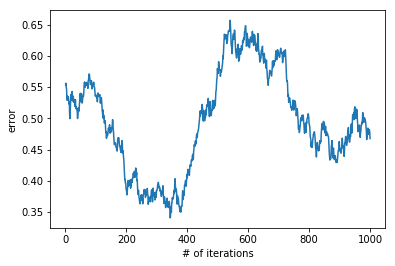

In [54]:
import numpy as np
import pandas as pd
import math
import random
from scipy.optimize import minimize
from scipy import optimize as op
import matplotlib.pyplot as plt

'''
Simulating one trajectory of system, here we use A,B to represent system parameter, in reality, we
can not access A, B, but we can get x(t+1). Since this is simulation we just use x(t_1) = A*x(t) + B*u(t) to
represent real x(t+1). Moreover, we use the finite horizon problem to approximate the infinite horizion problem.
'''
def one_trajectory_sim(step_num, x0, K, A, B, Q, R):
  x1 = x0 
  reward0 = 0
  reward1 = 0
  sigma0 = np.zeros(np.dot(x0, x0.transpose()).shape)
  sigma1 = np.zeros(np.dot(x0, x0.transpose()).shape)
  for i in range(step_num):
    reward0 = reward1
    sigma0  = sigma1
    x0 = x1
    ut = -np.dot(K, x0)
    reward1 = np.dot(np.dot(x0.transpose(), Q), x0) + np.dot(np.dot(ut.transpose(), R), ut) + reward0
    sigma1  = np.dot(x0, x0.transpose()) + sigma0
    x1 = np.dot(A, x0) + np.dot(B, ut)
    
    #If cost value is already convergent, then we will not waste computation resource on this trajectory.
    #Hence, breaking the loop.
    if (abs(np.linalg.norm(x1-x0)) <= 0.001):
      #print("success converge to steady value at:", i)
      break;
  return reward1, sigma1



"""
Calculating the gradient of cost function without first order information. Subsequentely, this gradient is used to
update control gain K. One should tuning leaning rate carefully so as to get the best result.
"""
def cost_gradient(K, m, r, step_num, A, B, Q, R):
  (k, d) = [A.shape[0], B.shape[0]]
  Cost_sum = 0
  Sigma_sum = 0
  Ki = K
  mean = np.array([0 for i in range(d)])
  cov3 = r*r*np.identity(d)
  for i in range(m):
    #Adding disturbence to K, this value should guarantee stability of cost value.
    #Ui = np.zeros((1, k*d)) + r*r/(k*d) + np.random.randint(-1, 1, size = (1, k*d))/(1/r*1000)
    #Ui = Ui.reshape(k,d)
    Ui = np.random.multivariate_normal(mean,cov3,k)/800
    Ki = Ki + Ui
    
    #Initilize x0, this value should guarantee stability of cost value.
    #x0 = np.array([[random.randint(-1000, 1000)/1000 for i in range(d)]]).transpose()
    x0 = np.array([[random.choice([4, 5, 6])]])
    Cost, Sigma = one_trajectory_sim(step_num, x0, Ki, A, B, Q, R)
    Cost_sum = Cost_sum + d/(r*r)*Cost*Ui
    Sigma_sum = Sigma_sum + Sigma
    
  #Updating control gain by its gradient.
  gradient =  K - (0.0005*np.dot((Cost_sum/m), np.linalg.inv(Sigma_sum/m))) #Natrual gradient
  #gradient = K - 0.00005*(Cost_sum/m)   #Policy gradient
  #print("Calculated gain:\n", gradient)
  return gradient




"""
Gradient decent method is utilized to achieve the best control gain K. 
"""
def onePoint_lqr_gain(K, K_star, A, B, Q, R, N):
  #Parameter that should be tuned manually
  m = 500
  r = 0.001
  step_num = 500
  error = [abs(np.linalg.norm(K_star - K))]
  for ss in range(N):
    #Display current progress.(progress bar)
    if (ss%100 == 0):
      print("# of excuted iterations:",  ss)
    K = cost_gradient(K, m, r, step_num, A, B, Q, R)
    
    #Calculating error (K_opt and K_one)
    error.append(abs(np.linalg.norm(K_star - K)))
    
    #Some result may blow up, thus leading to exception of this programe
    if (abs(np.linalg.norm(K_star - K)) >= 100):
      return K, error
    if (np.isnan(K[0,0])):
      print("Encounter NAN, exist!")
      return K, error
  return K, error 



    
"""
Testing the one point gradient method, moreover, comparing it with optimal control gain obtained before.
Specifically, error between K_opt and K_one over iteration time is illustrated.
"""
def test_opt_gain():
#   A = np.array([[1, 0, -10],[-1, 1, 0],[0, 0, 1]])
#   B = np.array([[1, -10, 0], [0, 1, 0], [-1, 0, 1]])
#   Q = np.array([[2, -1, 0], [-1, 2, -1], [0, -1, 2]])
#   R = np.array([[5, -3, 0], [-3, 5, -2], [0, -2, 5]])
  
  A = np.array([[5]])
  B = np.array([[0.33]]) 
  Q = np.array([[1]])
  R = np.array([[1]])
  (k, d) = [A.shape[0], B.shape[0]]
  
  #x0 = np.array([[random.randint(-1000, 1000)/1000 for i in range(d)]]).transpose()
  x0 = np.array([[random.choice([4, 5, 6])]])
  
  K_star = optimal_lqr_gain(A, B, Q, R)
  mean = np.array([0 for i in range(d)])
  cov3 = 1*np.identity(d)
  K = optimal_lqr_gain(A, B, Q, R) + np.random.randint(-1000,1000, size = (k, d))/1000
  #K = optimal_lqr_gain(A, B, Q, R) + np.random.multivariate_normal(mean,cov3,k)/10
  
  print("Optimal gain:\n", optimal_lqr_gain(A, B, Q, R))
  print("Initial gain:\n", K)
  cost_gradient(K, 10, 0.01, 100, A, B, Q, R)
  print("Calculated gain:\n", cost_gradient)
  
  #Calculate the difference between cost of optimal and initial state.
  print("Cost of Optimal gain:\n", one_trajectory_sim(1000, x0, K_star, A, B, Q, R)[0])
  print("Cost of Initial gain:\n", one_trajectory_sim(1000, x0, K, A, B, Q, R)[0])
  
  
  [one_K, error] = onePoint_lqr_gain(K, K_star, A, B, Q, R,1000)
  print("One point method:", one_K)
  
  #Draw the learning picture
  plt.plot([i+1 for i in range(len(error)- 1)], error[0: len(error)- 1])
  plt.xlabel("# of iterations")
  plt.ylabel("error")
  plt.show()
test_opt_gain()